In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import xarray as xr
from matplotlib import pyplot as plt

import xarray_raster_vector as xrv

xrv.info()

The following accessors have been added:

<df.rv accessor>
    df.rv.to_raster ( da_target, by_column=None, **joblib_kwargs )
    df.rv.crop_to_da ( da )
    df.rv.get_bbox_latlon ( as_geopandas=False )

<xr.rv accessor>
    da.rv.to_polygons ( buffer_dist=0, simplify_dist=0, combine_polygons=False, names=None )
    da.rv.to_raster ( filname, **kwargs )
    da.rv.get_bbox_latlon ( as_geopandas=False )
    da.rv.get_utm_code ()

<xr.morph accessor>
    da.morph.binary_opening ( footprint=None, out=None, *, mode='ignore' )
    da.morph.binary_closing ( footprint=None, out=None, *, mode='ignore' )
    da.morph.binary_erosion ( footprint=None, out=None, *, mode='ignore' )
    da.morph.binary_dilation ( footprint=None, out=None, *, mode='ignore' )
    da.morph.remove_small_holes ( area_threshold=64, connectivity=1, *, out=None )
    da.morph.remove_small_objects ( min_size=64, connectivity=1, *, out=None )
    da.morph.label ( background=None, return_num=False, connectivity=None )
    da.mo

In [8]:
def plot_map_180x360(da, title='', **kwargs):
    props = dict(aspect=2, size=5, cbar_kwargs=dict(pad=0.02))
    
    if 'ax' in kwargs:
        props.pop('size')
        props.pop('aspect')

    props.update(kwargs)
    img = da.plot(**props)
    img.axes.set_title(title, x=0, ha='left')

    return img.figure, img.axes, img

# Download data

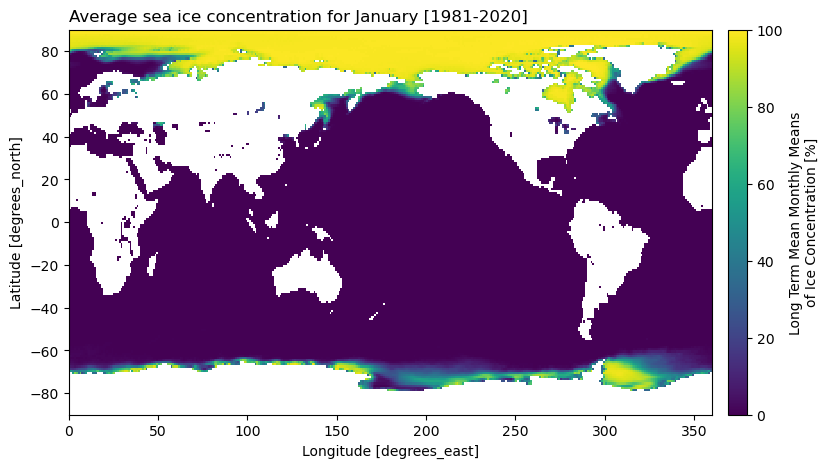

In [9]:
url_opendap = 'http://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2/icec.ltm.nc'
ds_seaice = xr.open_dataset(url_opendap, decode_times=False, chunks={})

da_seaice_jan = (
    ds_seaice.icec
    .isel(time=0)         # select january
    .load()               # download the data from the opendap server
    .rio.write_crs(4326)  # write the coordinate reference system (lat, lon) to avoid warnings
)

fig, ax, img = plot_map_180x360(da_seaice_jan, title='Average sea ice concentration for January [1981-2020]')

# Make mask for demo

In [10]:
mask_bool = (da_seaice_jan > 0).assign_attrs(long_name='Sea ice mask')  # create bool array

mask_int = (
    (da_seaice_jan.where(lambda x: x!=0).fillna(-1) // 50)  # create two levels for sea ice [0-2]
    .clip(-1, 1)  # clip the values to -1, 0, 1
    .astype(int)  # convert the values to integers - NB, conversion only works for bool / int 
    .assign_attrs(long_name='Sea ice levels')  # for nice plot label
)

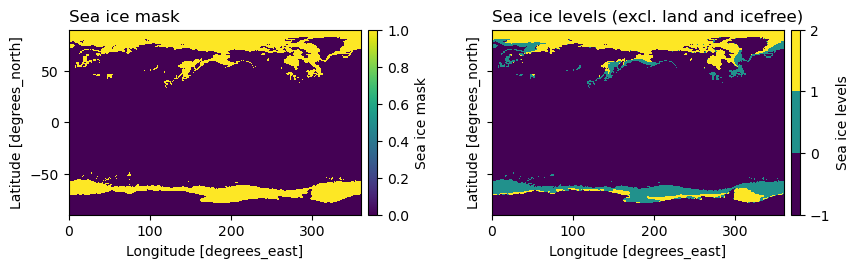

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 2.4), sharex=True, sharey=True)
img1 = plot_map_180x360(mask_bool, title='Sea ice mask', ax=ax[0])[-1]
img2 = plot_map_180x360(mask_int, title='Sea ice levels (excl. land and icefree)', levels=range(-1, 3), cmap='viridis', ax=ax[1])[-1]

# To vector polygons (geopandas)

In [12]:
df_single = mask_bool.rv.to_polygons(combine_polygons=True)
df_single

,geometry
0,"MULTIPOLYGON (((46.00000 -57.00000, 44.00000 -..."


In [13]:
# with integers, returns mutliple rows for each value - we can also assign names 
df_multi = mask_int.rv.to_polygons(names=['icefree_land', 'low', 'med'])
df_multi

,geometry,class
0,"MULTIPOLYGON (((111.00000 -67.00000, 111.00000...",icefree_land
1,"MULTIPOLYGON (((13.00000 -71.00000, 13.00000 -...",low
2,"MULTIPOLYGON (((5.00000 -70.00000, 5.00000 -71...",med


# Back to raster:

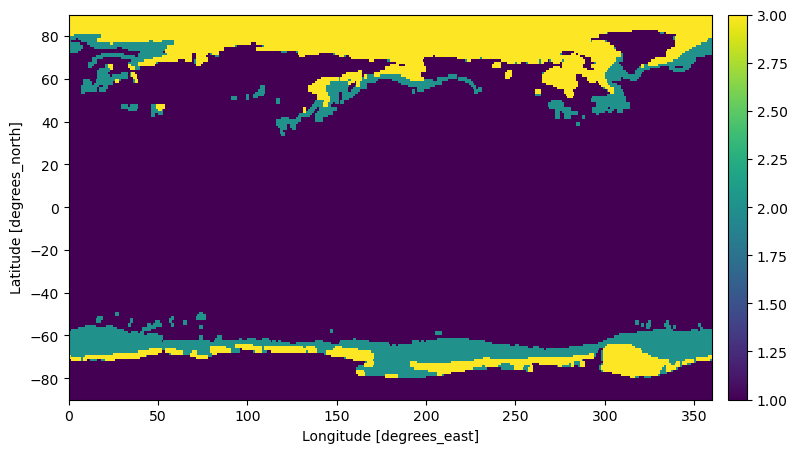

In [14]:
mask_backwards = df_multi.rv.to_raster(mask_int)
fig, ax, img = mask_backwards.pipe(plot_map_180x360)

# Mask cleaning operations

In [24]:
mask_bool.morph

<xr.morph accessor>
    da.morph.binary_opening ( footprint=None, out=None, *, mode='ignore' )
    da.morph.binary_closing ( footprint=None, out=None, *, mode='ignore' )
    da.morph.binary_erosion ( footprint=None, out=None, *, mode='ignore' )
    da.morph.binary_dilation ( footprint=None, out=None, *, mode='ignore' )
    da.morph.remove_small_holes ( area_threshold=64, connectivity=1, *, out=None )
    da.morph.remove_small_objects ( min_size=64, connectivity=1, *, out=None )
    da.morph.label ( background=None, return_num=False, connectivity=None )
    da.morph.clean ( holes=64, objects=64, opening=None, closing=None ) 

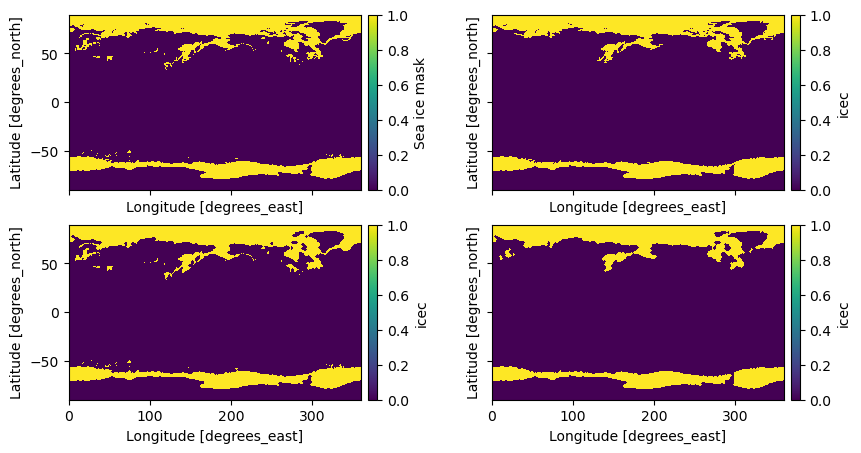

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True)
_ = plot_map_180x360(mask_bool, ax=ax[0, 0])
_ = plot_map_180x360(mask_bool.morph.remove_small_objects(min_size=100), ax=ax[0, 1])
_ = plot_map_180x360(mask_bool.morph.binary_closing(), ax=ax[1, 0])

# perform: remove_small_objects, remove_small_holes, binary_closing, binary_opening all in one go
_ = plot_map_180x360(mask_bool.morph.clean(), ax=ax[1, 1])

(<Figure size 1000x500 with 2 Axes>,
 <Axes: xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>,
 <matplotlib.collections.QuadMesh at 0x169a3c990>)

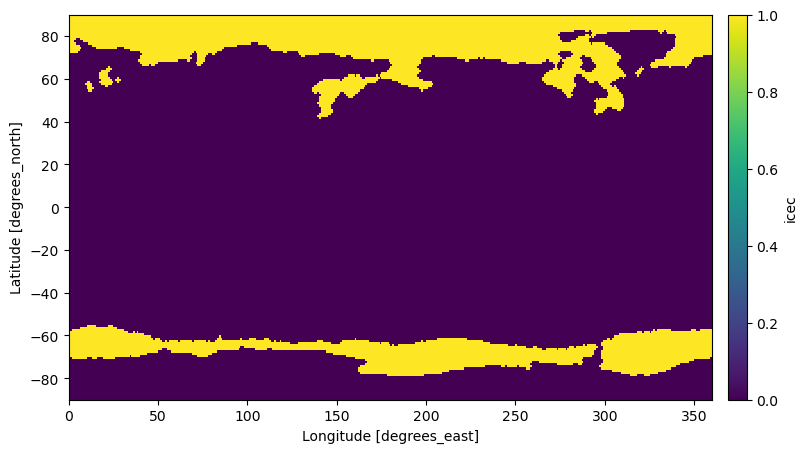